In [17]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import tensorflow as tf


In [18]:
model = keras.applications.xception.Xception(
    # 상위 층에 있는 신경망을 자름 (Conv만 남음)
    weights="imagenet",
    include_top=False)

In [19]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_8
block3_sepconv1
block3_sepconv2
conv2d_9
block4_sepconv1
block4_sepconv2
conv2d_10
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_11
block14_sepconv1
block14_sepconv2


In [20]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [21]:
layer_name = "block8_sepconv1" # Xception 합성곱 기반에 있는 다른 층의 이름으로 바꿀 수 있음
layer = model.get_layer(name=layer_name) # 관심 대상인 층의 객체
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
# model.input과 layer.output을 사용해서 입력 이미지가 주어졌을 때 해당 층의 출력을 반환하는 모델을 만듦
#block1_conv1, block1_conv2, block2_sepconv1, block2_sepconv2, conv2d, block3_sepconv1

In [22]:
# Xception Model의 입력은 keras.applications.xception.preprocess_input()로 전처리되어야 함
# activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

In [23]:
# 이 손실 함수는 이미지 텐서와 필터 인덱스(정수)를 입력으로 받음
def compute_loss(image, filter_index):
    # 위에서 block3_sepconv1까지 자른 모델에 이미지를 통과시켜 출력을 activation에 저장
    activation = feature_extractor(image)
    # 손실에 경계 픽셀을 제외시켜 경계에 나타나는 부수 효과를 제외
    # 활성화 테두리를 따라 두 픽셀을 제외
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    # 활성화 값의 평균을 손실 함수로 사용
    return tf.reduce_mean(filter_activation)

In [24]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        # 이미지 텐서는 텐서플로 변수가 아니기 때문에 명시적으로 지정
        # 그레이디언트 테이프는 텐서플로 변수만 자동으로 감시
        tape.watch(image)
        # 이미지가 필터를 얼마나 활성화하는지 나타내는 스칼라 손실을 계산
        loss = compute_loss(image, filter_index)
    # 이미지에 대한 손실의 그레이디언트를 계산
    grads = tape.gradient(loss, image)
    # 그레이디언트 정규화 (L2 norm 값으로 나누어 규제)
    # 규제한 것을 더하고 있으므로 상승이 빨라짐
    grads = tf.math.l2_normalize(grads)
    # 필터를 더 강하게 활성화시키는 방향으로 이미지를 조금 이동
    image += learning_rate * grads
    # 반복 루프에서 이 스텝 함수를 실행할 수 있도록 업데이트된 이미지를 반환
    return image

In [25]:
img_width = 200
img_height = 200

In [26]:
def generate_filter_pattern(filter_index):
    # 경사 상승법 단계를 적용할 횟수
    iterations = 30
    # 학습률을 10을 줌
    learning_rate = 10.
    # 랜덤한 값으로 이미지 텐서를 초기화
    # Xception 모델은 [-1,1] 범위의 입력 값을 기대함.
    # 여기에서는 0.5를 중심으로 범위를 선택 
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [27]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    # -2 ~ 2까지
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

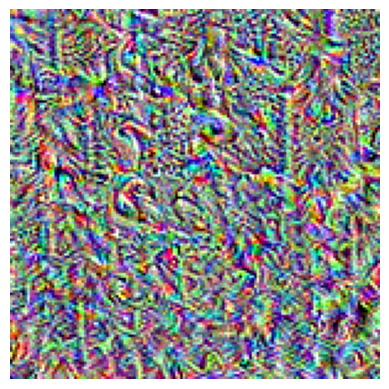

In [28]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

In [29]:
all_images = []
for filter_index in range(64):
    print(f"{filter_index}번 필터 처리중")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

0번 필터 처리중
1번 필터 처리중
2번 필터 처리중
3번 필터 처리중
4번 필터 처리중
5번 필터 처리중
6번 필터 처리중
7번 필터 처리중
8번 필터 처리중
9번 필터 처리중
10번 필터 처리중
11번 필터 처리중
12번 필터 처리중
13번 필터 처리중
14번 필터 처리중
15번 필터 처리중
16번 필터 처리중
17번 필터 처리중
18번 필터 처리중
19번 필터 처리중
20번 필터 처리중
21번 필터 처리중
22번 필터 처리중
23번 필터 처리중
24번 필터 처리중
25번 필터 처리중
26번 필터 처리중
27번 필터 처리중
28번 필터 처리중
29번 필터 처리중
30번 필터 처리중
31번 필터 처리중
32번 필터 처리중
33번 필터 처리중
34번 필터 처리중
35번 필터 처리중
36번 필터 처리중
37번 필터 처리중
38번 필터 처리중
39번 필터 처리중
40번 필터 처리중
41번 필터 처리중
42번 필터 처리중
43번 필터 처리중
44번 필터 처리중
45번 필터 처리중
46번 필터 처리중
47번 필터 처리중
48번 필터 처리중
49번 필터 처리중
50번 필터 처리중
51번 필터 처리중
52번 필터 처리중
53번 필터 처리중
54번 필터 처리중
55번 필터 처리중
56번 필터 처리중
57번 필터 처리중
58번 필터 처리중
59번 필터 처리중
60번 필터 처리중
61번 필터 처리중
62번 필터 처리중
63번 필터 처리중
